# Time Series Forecasting

This program should read in a .csv file and save the output as .png files in the folder time_series_forecast_figures

### Packages

- pip install -U scikit-learn
- pip install statsmodels
- pip install matplotlib
- pip install tqdm

### Libraries

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import tqdm.notebook
import os

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Global Constants

In [2]:
# FILE TO LOOK AT:
FILENAME = 'I01R1.csv'

# Van Column from file to assess
VAN_COLUMN = 'v0_SF6'

# Number of values to use for training
RESAMPLE = '30s'

# Proportion of values for training:
TRAIN_PROP = 0.70

# Path to Read:
readPath = '../Dataset/master/'+str(FILENAME)

# Save to path:
savePath = 'time_series_forecast_figures/'+str(FILENAME[:5])+'_'\
                                          +str(VAN_COLUMN[:2])+'_'+\
                                          'RESAMP='+RESAMPLE+'_'+\
                                          'TPROP='+str(TRAIN_PROP)+'_'

### Read in Data and Plot

In [3]:
# Read CSV and display first 10 rows
df = pd.read_csv(readPath)
df.head()

,datetime,id,v0_SF6,v0_altitude,v0_latitude,v0_longitude,v1_SF6,v1_altitude,v1_latitude,v1_longitude,...,temp_10,temp_15,temp_20,temp_25,temp_30,temp_35,temp_40,temp_45,Wx,Wy
0,2003-06-29 14:00:00.000,0,0.0,353.0,35.469797,-97.5147,0.0,NaN,35.470805,-97.515579,...,296.2000,296.000000,297.0,295.800000,296.9,296.8,295.600000,296.7,-2.373438,-1.541328
1,2003-06-29 14:00:00.500,1,0.0,353.0,35.469797,-97.5147,0.0,NaN,35.470805,-97.515579,...,296.2001,296.000111,297.0,295.800165,296.9,296.8,295.600133,296.7,-2.373886,-1.541128
2,2003-06-29 14:00:01.000,2,0.0,353.0,35.469797,-97.5147,0.0,NaN,35.470805,-97.515579,...,296.2002,296.000222,297.0,295.800331,296.9,296.8,295.600267,296.7,-2.374333,-1.540928
3,2003-06-29 14:00:01.500,3,0.0,353.0,35.469797,-97.5147,0.0,NaN,35.470805,-97.515579,...,296.2003,296.000333,297.0,295.800496,296.9,296.8,295.600400,296.7,-2.374781,-1.540728
4,2003-06-29 14:00:02.000,4,0.0,353.0,35.469797,-97.5147,0.0,NaN,35.470805,-97.515579,...,296.2004,296.000444,297.0,295.800661,296.9,296.8,295.600533,296.7,-2.375229,-1.540528


### Resample to 30 Second Intervals

In [4]:
# set df to datetime index
df.datetime = pd.to_datetime(df.datetime)
df.set_index(df.datetime, drop=True, inplace=True)

# resample to resample parameter based off datetime index
df = df.resample(RESAMPLE).mean()

# Reset the id column
df['id'] = np.arange(0,len(df),1)
df.head()

,id,v0_SF6,v0_altitude,v0_latitude,v0_longitude,v1_SF6,v1_altitude,v1_latitude,v1_longitude,v2_SF6,...,temp_10,temp_15,temp_20,temp_25,temp_30,temp_35,temp_40,temp_45,Wx,Wy
datetime,,,,,,,,,,,,,,,,,,,,,
2003-06-29 14:00:00,0,0.0,353.0,35.469797,-97.5147,0.0,NaN,35.470805,-97.515579,0.0,...,296.20295,296.003278,297.0,295.804878,296.9,296.8,295.603933,296.7,-2.386644,-1.535372
2003-06-29 14:00:30,1,0.0,353.0,35.469797,-97.5147,0.0,NaN,35.470805,-97.515579,0.0,...,296.20895,296.009944,297.0,295.814798,296.9,296.8,295.611933,296.7,-2.413482,-1.523026
2003-06-29 14:01:00,2,0.0,353.0,35.469797,-97.5147,0.0,NaN,35.470805,-97.515579,0.0,...,296.21495,296.016611,297.0,295.824719,296.9,296.8,295.619933,296.7,-2.440286,-1.510327
2003-06-29 14:01:30,3,0.0,353.0,35.469797,-97.5147,0.0,NaN,35.470805,-97.515579,0.0,...,296.22095,296.023278,297.0,295.834640,296.9,296.8,295.627933,296.7,-2.467051,-1.497275
2003-06-29 14:02:00,4,0.0,353.0,35.469797,-97.5147,0.0,NaN,35.470805,-97.515579,0.0,...,296.22695,296.029944,297.0,295.844560,296.9,296.8,295.635933,296.7,-2.493773,-1.483871


### Visualization

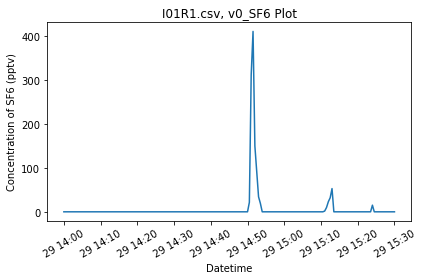

In [5]:
# Plot time series
fig, ax = plt.subplots()

ax.plot(df.index, df.loc[:, str(VAN_COLUMN)])

ax.set_title(str(FILENAME)+', '+ str(VAN_COLUMN)+' Plot')
ax.set_xlabel('Datetime')
ax.set_ylabel('Concentration of SF6 (pptv)')

plt.xticks(rotation=30)
plt.tight_layout()

# save figure to folder
plt.savefig(savePath+'F01_Plot.png', dpi=300)

### Exploration

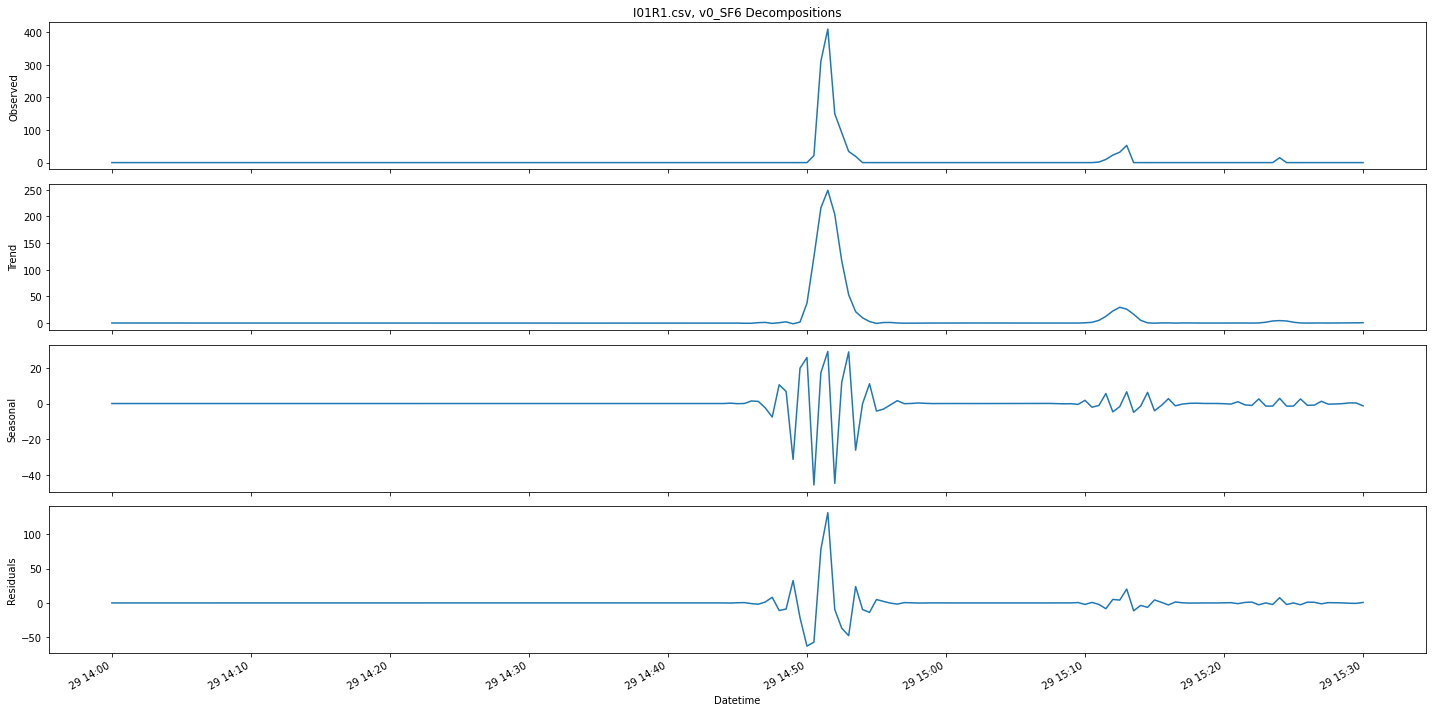

In [6]:
# Decompose time series into 3 components: trend, seasonal component, residuals
decomposition = STL(df.loc[:, str(VAN_COLUMN)], period=3).fit()

#Plot all components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(20,10))

ax1.set_title(str(FILENAME)+', '+ str(VAN_COLUMN)+' Decompositions')
ax1.plot(df.index, decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(df.index, decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(df.index, decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(df.index, decomposition.resid)
ax4.set_ylabel('Residuals')
ax4.set_xlabel('Datetime')

plt.xticks(rotation=30)

fig.autofmt_xdate()
plt.tight_layout()

# save decomps to folder
plt.savefig(savePath+'F02_Decomps.png', dpi=300)
plt.show()

### Modeling

In [7]:
# Test for stationarity
ad_fuller_result = adfuller(df[str(VAN_COLUMN)])

# Print ADF statistic and p-value
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.720426949746124
p-value: 6.961912265264643e-07


In [8]:
# Difference the series
y_diff = np.diff(df[str(VAN_COLUMN)], n=1)

# Test for stationarity
ad_fuller_result = adfuller(y_diff)

# Print ADF statistics and p-value
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -8.076932489449362
p-value: 1.4967756629847066e-12


In [9]:
# Seasonal difference
y_diff_seasonal_diff = np.diff(y_diff, n=2)

# Test for stationarity
ad_fuller_result = adfuller(y_diff_seasonal_diff)

# Print ADF statistic and p-value
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -7.685552577668317
p-value: 1.464909033054939e-11


In [10]:
# Re-index to work with model
df = df.reset_index().set_index('id')
df.head()

,datetime,v0_SF6,v0_altitude,v0_latitude,v0_longitude,v1_SF6,v1_altitude,v1_latitude,v1_longitude,v2_SF6,...,temp_10,temp_15,temp_20,temp_25,temp_30,temp_35,temp_40,temp_45,Wx,Wy
id,,,,,,,,,,,,,,,,,,,,,
0,2003-06-29 14:00:00,0.0,353.0,35.469797,-97.5147,0.0,NaN,35.470805,-97.515579,0.0,...,296.20295,296.003278,297.0,295.804878,296.9,296.8,295.603933,296.7,-2.386644,-1.535372
1,2003-06-29 14:00:30,0.0,353.0,35.469797,-97.5147,0.0,NaN,35.470805,-97.515579,0.0,...,296.20895,296.009944,297.0,295.814798,296.9,296.8,295.611933,296.7,-2.413482,-1.523026
2,2003-06-29 14:01:00,0.0,353.0,35.469797,-97.5147,0.0,NaN,35.470805,-97.515579,0.0,...,296.21495,296.016611,297.0,295.824719,296.9,296.8,295.619933,296.7,-2.440286,-1.510327
3,2003-06-29 14:01:30,0.0,353.0,35.469797,-97.5147,0.0,NaN,35.470805,-97.515579,0.0,...,296.22095,296.023278,297.0,295.834640,296.9,296.8,295.627933,296.7,-2.467051,-1.497275
4,2003-06-29 14:02:00,0.0,353.0,35.469797,-97.5147,0.0,NaN,35.470805,-97.515579,0.0,...,296.22695,296.029944,297.0,295.844560,296.9,296.8,295.635933,296.7,-2.493773,-1.483871


### Train/Test Split

In [11]:
# calculate number of training values based off train 
# proportion and length of data.
TRAIN_VAL = int(TRAIN_PROP * len(df))

# create separate lists containg vals for train/test
train = df.loc[:TRAIN_VAL, str(VAN_COLUMN)]
test = df.loc[TRAIN_VAL:, str(VAN_COLUMN)]

print(len(train), len(test))

127 55


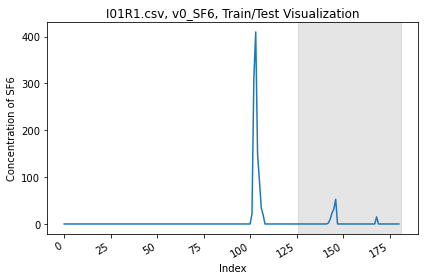

In [12]:
# Visualize train/test split
fig,ax = plt.subplots()
                     
ax.plot(df.index, df.loc[:, str(VAN_COLUMN)])
ax.set_title(str(FILENAME)+', '+ str(VAN_COLUMN)+', Train/Test Visualization')
ax.set_xlabel('Index')
ax.set_ylabel('Concentration of SF6')
ax.axvspan(TRAIN_VAL, len(df), color='#808080', alpha=0.2)

plt.xticks(rotation=30)

fig.autofmt_xdate()
plt.tight_layout()

# save figure to file
plt.savefig(savePath+'F03_TrainVsTest.png', dpi=300)
plt.show()

### SARIMA(p,1,q)(P,1,Q)12

- **p**: Trend autoregression order.
- **d**: Trend difference order.
- **q**: Trend moving average order.

- **P**: Seasonal autoregressive order.
- **D**: Seasonal difference order.
- **Q**: Seasonal moving average order.
- **m**: The number of time steps for a single seasonal period.

In [13]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list],\
                     order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    '''
    Takes in a list of values, a list of outputs, an order list,
    and SARIMAX parameters to compute a dataframe of several
    combinations of p/q/P/Q value fits using SARIMAX.
    
    Args:
        endog (list or pd.Series): a list of endogenous values to train
                                   the model with
        exog (list or pd.Series): a list of exogenous values to train 
                                  the model with
        order_list (list): list of all possible product combinations between
                           p/q/P/Q parameters
        d (int): integer that represents the trend difference order of
                 the data
        D (int): integer that represents the seasonal difference order
                 of the data
        s (int): integer that represents the seasonality of the data
    
    Returns:
        result_df (pd.DataFrame): a DataFrame containing the p/q/P/Q
    '''
    results = []
    for order in tqdm.notebook.tqdm(order_list):
        try:
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue   
        results.append([order, model.aic])   
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [14]:
# Define range of values for p, q, P, and Q
ps = range(0,5,1)
qs = range(0,5,1)
Ps = range(0,5,1)
Qs = range(0,5,1)

# Create list of all unique combinations
order_list = list(product(ps,qs,Ps,Qs))

# Set constants
d = 1
D = 1
s = 3
m = 3

In [15]:
# Find the (p,d,q)(P,D,Q)m combination with the lowest AIC
SARIMA_result_df = optimize_SARIMAX(train, None, order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(1, 2, 0, 1)",1211.498994
1,"(2, 2, 0, 1)",1212.961389
2,"(1, 2, 0, 2)",1213.388330
3,"(1, 2, 1, 1)",1213.399582
4,"(3, 2, 0, 1)",1214.794747
...,...,...
283,"(0, 0, 1, 0)",1300.489187
284,"(0, 1, 0, 0)",1309.458225
285,"(1, 1, 0, 0)",1311.443636
286,"(1, 0, 0, 0)",1326.970342


In [16]:
# Does order of these numbers need to change?
# Fit optimal model to study its residuals
p = SARIMA_result_df['(p,q,P,Q)'][0][0]
q = SARIMA_result_df['(p,q,P,Q)'][0][1]
P = SARIMA_result_df['(p,q,P,Q)'][0][2]
Q = SARIMA_result_df['(p,q,P,Q)'][0][3]

SARIMA_model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,m), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

# Print model summary
print(SARIMA_model_fit.summary())

# save summary to folder as .png
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(SARIMA_model_fit.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(savePath+'F04_SARIMAX_Summary.png')
plt.close()

                                      SARIMAX Results                                      
Dep. Variable:                              v0_SF6   No. Observations:                  127
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 3)   Log Likelihood                -600.749
Date:                             Mon, 26 Sep 2022   AIC                           1211.499
Time:                                     01:28:49   BIC                           1225.560
Sample:                                          0   HQIC                          1217.211
                                             - 127                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4110      0.068      6.079      0.000       0.278       0.543
ma.L1         -0.2468      

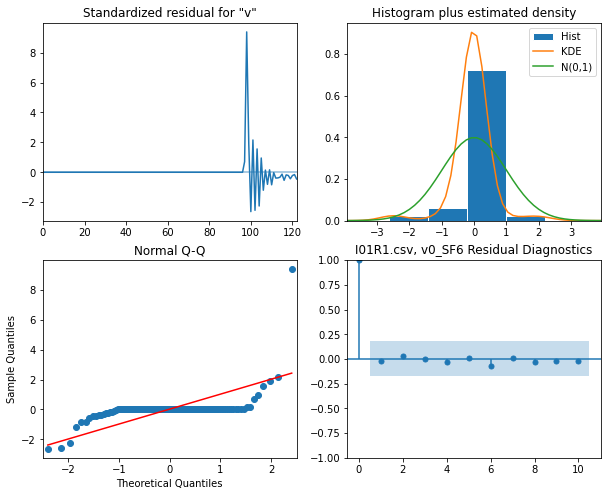

In [17]:
# Plot residual's diagnostics
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

plt.title(str(FILENAME)+', '+ str(VAN_COLUMN)+' Residual Diagnostics')

# save figure to file
plt.savefig(savePath+'F05_Residuals.png', dpi=300)
plt.show()

In [18]:
# Run the Ljung-Box test
residuals = SARIMA_model_fit.resid

df_ljb = pd.DataFrame(acorr_ljungbox(residuals, np.arange(1, 11, 1)))
df_ljb

,lb_stat,lb_pvalue
1,0.043848,0.834137
2,0.151757,0.926929
3,0.151847,0.984961
4,0.301228,0.989735
5,0.317676,0.997297
6,1.054904,0.983445
7,1.081037,0.993413
8,1.236659,0.996266
9,1.300933,0.998372
10,1.388773,0.999242


### Forecasting

In [19]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    '''
    Creates a rolling forecast using the given data and the given
    method of forecasting.
    
    Args:
        df (pd.DataFrame): a dataframe containing data to forecast
        train_len (int): amount of values used to train model
        horizon (int): how far ahead to predict values
        window (int): how many values ahead to be predicted
        method (str): distinguish between 'last_season' or 'SARIMA'
                      forecasting methods.
    
    Returns:
        pred_last_season (list): list of forecasted values using
                                 last season method
                or
                
        pred_SARIMA (list): list of forecasted values using SARIMA
                            method
    '''
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'last_season':
        pred_last_season = []
        for i in range(train_len, total_len, window):
            last_season = df[str(VAN_COLUMN)][i-window:i].values
            pred_last_season.extend(last_season)
        return pred_last_season
    
    elif method == 'SARIMA':
        pred_SARIMA = []
        for i in range(train_len, total_len, window):           
            model = SARIMAX(df[str(VAN_COLUMN)][:i], order=(p,d,q),\
                            seasonal_order=(P,D,Q,s),simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i+window-1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
        return pred_SARIMA

In [20]:
# make a dataframe to hold predictions
pred_df = df.loc[TRAIN_VAL:, [str(VAN_COLUMN)]]
pred_df.head(2)

,v0_SF6
id,
126,0.0
127,0.0


In [21]:
# Define length of training set, horizon of forecast, and the window of forecast
TRAIN_LEN = TRAIN_VAL

# want a forecast within the end of our collected data to compare
WINDOW = len(test)
HORIZON = WINDOW

# Perform rolling forecast with the naive seasonal baseline
pred_df['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')

# Display the predictions
pred_df.head()

,v0_SF6,last_season
id,,
126,0.0,0.0
127,0.0,0.0
128,0.0,0.0
129,0.0,0.0
130,0.0,0.0


In [22]:
# Perform rolling forecast with the SARIMA model
pred_df['SARIMA'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

# Display the predicitions
pred_df.head()

# SAVE PREDICTION DF
pred_df.to_csv(savePath+'Predictions.csv')
pred_df.head()

,v0_SF6,last_season,SARIMA
id,,,
126,0.0,0.0,14.068351
127,0.0,0.0,21.849605
128,0.0,0.0,18.058903
129,0.0,0.0,25.035628
130,0.0,0.0,26.773072


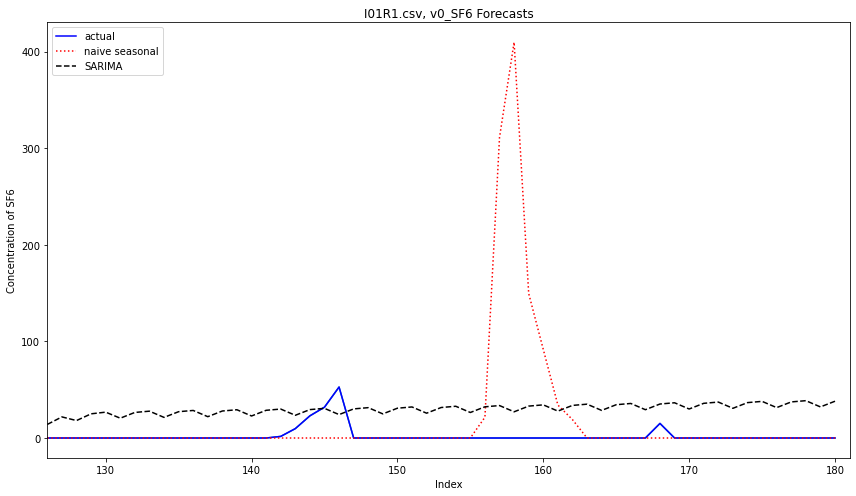

In [23]:
# Plot actual and predicted values
fig, ax = plt.subplots()

ax.plot(df.loc[:, str(VAN_COLUMN)])
ax.plot(pred_df.loc[:, str(VAN_COLUMN)], 'b-', label='actual')
ax.plot(pred_df.last_season, 'r:', label='naive seasonal')
ax.plot(pred_df.SARIMA, 'k--', label='SARIMA')

ax.set_title(str(FILENAME)+', '+ str(VAN_COLUMN)+' Forecasts')
ax.set_xlabel('Index')
ax.set_ylabel('Concentration of SF6')

ax.legend(loc=2)

plt.xlim(TRAIN_VAL, len(df))
plt.tight_layout()

# save figure to folder
plt.savefig(savePath+'F06_ForecastsPlot.png', dpi=300)
plt.show()

### Evaluate

In [24]:
def mae(y_true: list, y_pred: list) -> float:
    '''
    Computes the mean absolute error between the values of
    two lists.
    
    Args:
        y_true (list): list of actual data values
        y_pred (list): list of predicted data values
    
    Returns:
        (float): the mean absolute error of the two lists
    '''
    return np.mean(np.abs((y_true - y_pred)))

In [25]:
# get the MAE of the two predictions respective to the true data values
mae_naive_seasonal = mae(pred_df[str(VAN_COLUMN)], pred_df.last_season)
mae_SARIMA = mae(pred_df[str(VAN_COLUMN)], pred_df.SARIMA)

print(mae_naive_seasonal, mae_SARIMA)

21.290757575757578 28.376675812266438


In [26]:
def calc_scaler(mae1, mae2):
    '''
    Given two float values, finds a value to scale
    them both by to where they are both less than 50.
    
    Args:
        mae1 (float): a float value
        mae2 (float): a float value comparable to mae1
        
    Returns:
        scaler (float): a value to scale down the given
                        float values mae1 and mae2
    '''
    scaler = 1
    for i in range(0,5):
        if( mae1*scaler > 50 or mae2*scaler > 50):
            scaler *= (1/10)
    return scaler

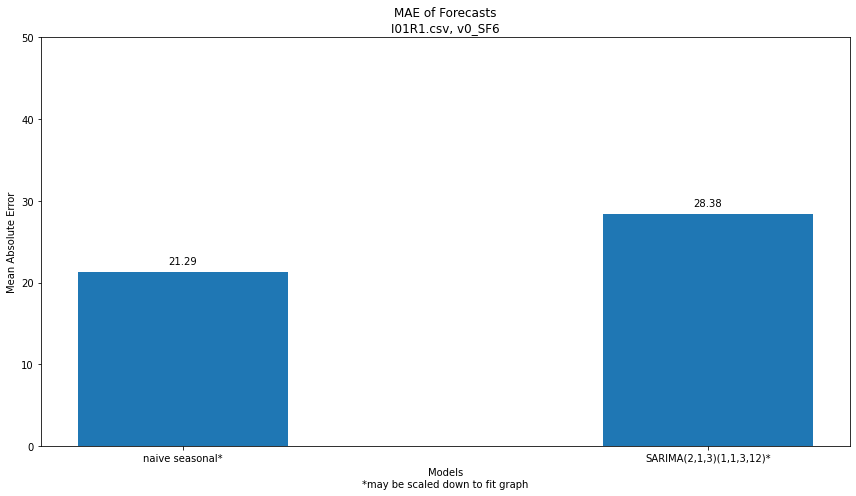

In [27]:
# plot the mean absolute errors together to visualize
fig, ax = plt.subplots()

x = ['naive seasonal*', 'SARIMA(2,1,3)(1,1,3,12)*']

scaler = calc_scaler(mae_naive_seasonal, mae_SARIMA)
y = [mae_naive_seasonal * scaler, mae_SARIMA * scaler]

ax.bar(x, y, width=0.4)
ax.set_title('MAE of Forecasts\n'+str(FILENAME)+', '+ str(VAN_COLUMN))
ax.set_xlabel('Models\n*may be scaled down to fit graph')
ax.set_ylabel('Mean Absolute Error')
ax.set_ylim(0, 50)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

# save mae figure to file
plt.savefig(savePath+'F07_MAE.png', dpi=300)
plt.show()